In [496]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline 
import seaborn as sns
import pandas as pd
from scipy import stats

from sklearn.metrics import silhouette_score
from sklearn.cluster import KMeans

import pickle

import warnings
warnings.filterwarnings('ignore')

## <center>ЗАДАЧА<center>

Задача без учителя: сегментировать клиентов магазина, используя сведения об их поле, возрасте, годовом доходе и покупательском скоринге.

## <center>ПЛАН РЕШЕНИЯ<center>

[Глава 0. Загрузка данных](#part0)

[Глава 1. Разведочный анализ EDA](#part1)\
[$1.1$. Приведение типов](#par1.1) \
[$1.2$. Анализ количественных признаков](#par1.2) \
[$1.3$. Обработка выбросов в количественных признаках](#par1.3) \
[$1.4$. Анализ категориальных признаков](#par1.4) \
[$1.5$. Оценка возможного числа кластеров](#par1.5) 

[Глава 2. Кластеризация методом KMeans](#part2)\
[$2.1$.Определение оптимального числа кластеров](#par2.1) \
[$2.2$.Построение модели кластеризации KMeans и ее анализ](#par2.2) \
[$2.3$.Сохранение итоговой модели](#par2.3) 

## <center> Глава 0. Загрузка данных <a class="anchor" id="part0"></a><center>

**Описание датасета**

Датасет содержит сведения о покупателях магазина.

**CustomerID** -- ID пользователя

**Genrе** -- Пол

**Age** -- Возраст

**Annual Income** -- Годовой доход (тыс. $)

**Spending Score (1-100)** -- Оценка расходов

In [497]:
df = pd.read_csv('Mall_Customers.csv', encoding='cp1251')
df.head()

,CustomerID,Genre,Age,Annual Income (k$),Spending Score (1-100)
0,1,Male,19,15,39
1,2,Male,21,15,81
2,3,Female,20,16,6
3,4,Female,23,16,77
4,5,Female,31,17,40


In [498]:
df.shape

(200, 5)

Датасет содержит 200 наблюдений и 5 признаков.

In [499]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 5 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   CustomerID              200 non-null    int64 
 1   Genre                   200 non-null    object
 2   Age                     200 non-null    int64 
 3   Annual Income (k$)      200 non-null    int64 
 4   Spending Score (1-100)  200 non-null    int64 
dtypes: int64(4), object(1)
memory usage: 7.9+ KB


**Вывод:** пропусков в признаках нет, признак Genre имеет тип object, остальные -- int64.

## <center> Глава 1. Разведочный анализ EDA <a class="anchor" id="part1"></a><center>

### 1.1. Приведение типов<a class="anchor" id="par1.1"></a>

Поскольку признак CustomerID, содержащий уникальный ID, не несет статистической информации, рассматривать его не будем.

In [500]:
# Признак с ID покупателем переводим в категории
df['CustomerID'] = df['CustomerID'].astype('category')

In [501]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 5 columns):
 #   Column                  Non-Null Count  Dtype   
---  ------                  --------------  -----   
 0   CustomerID              200 non-null    category
 1   Genre                   200 non-null    object  
 2   Age                     200 non-null    int64   
 3   Annual Income (k$)      200 non-null    int64   
 4   Spending Score (1-100)  200 non-null    int64   
dtypes: category(1), int64(3), object(1)
memory usage: 18.3+ KB


**Вывод:** признак CustomerID приведен к типу категориального.

### 1.2. Анализ количественных признаков<a class="anchor" id="par1.2"></a>

In [502]:
# Собираем количественные признаки
num_features = ['Age', 'Annual Income (k$)', 'Spending Score (1-100)']

Проверим распределения количественных признаков на "нормальность".

In [503]:
# Используем критерий Шапиро-Уилка
# H0: случайная величина имеет нормальное распределение
# H1: случайная величина не имеет нормальное распределение

for num_feature in num_features:
    stat, p = stats.shapiro(df[num_feature])
    print(f'Проверка признака {num_feature}')
    print('Statistics=%.3f, p=%.3f' % (stat, p))
    # interpret
    alpha = 0.05
    if p > alpha:
        print('Sample looks Gaussian (fail to reject H0)\n')
    else:
        print('Sample does not look Gaussian (reject H0)\n')

Проверка признака Age
Statistics=0.952, p=0.000
Sample does not look Gaussian (reject H0)

Проверка признака Annual Income (k$)
Statistics=0.978, p=0.004
Sample does not look Gaussian (reject H0)

Проверка признака Spending Score (1-100)
Statistics=0.969, p=0.000
Sample does not look Gaussian (reject H0)



Для достоверности произведем визуальную оценку распределений признаков.

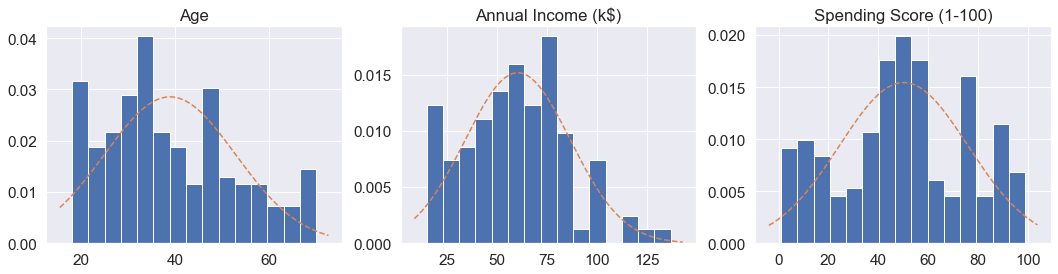

In [504]:
#Cтроим гистограммы для количественных признаков
fig, axes = plt.subplots(ncols=3)
fig.set_size_inches(18, 4)
axes = axes.flatten()

for num_feature, ax in zip(num_features, axes):
    ax.hist(df[num_feature], density=True, bins=15)
    
    loc = df[num_feature].mean()
    scale = df[num_feature].std()
    
    x_left, x_right = ax.get_xlim()
    x = np.linspace(x_left, x_right, 10000)
    y = stats.norm.pdf(x, loc=loc, scale=scale)
    
    ax.plot(x, y, linestyle='dashed')
    ax.set_title(num_feature)

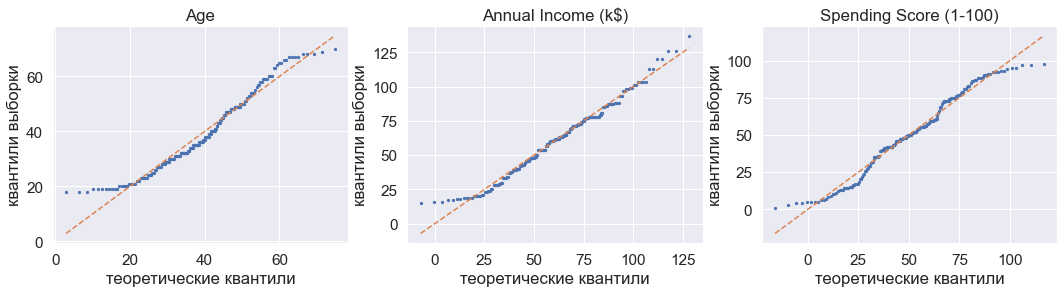

In [505]:
#Cтроим QQ-кривые для количественных признаков
fig, axes = plt.subplots(ncols=3)
fig.set_size_inches(18, 4)
axes = axes.flatten()

for num_feature, ax in zip(num_features, axes):
    samples = df[num_feature]
    
    loc = samples.mean()
    scale = samples.std()
    
    interval = np.linspace(0, 1, samples.shape[0])[1:-1]
    x = stats.norm.ppf(interval, loc=loc, scale=scale)
    y = np.quantile(samples, interval)
    
    ax.scatter(x, y, s=5)
    ax.plot(x, x, color='C1', linestyle='dashed')
    
    ax.set_title(num_feature)
    ax.set_xlabel('теоретические квантили')
    ax.set_ylabel('квантили выборки')

Визуальная оценка подтверждает показания критерия Шапиро-Уилка по поводу того, что закон распределения отличный от "нормального". 

In [506]:
#проверям равенство моды, медианы и среднего
for num_feature in num_features:
    print(f'{num_feature}: mean: {df[num_feature].mean()}, median: {df[num_feature].median()}, mode: {df[num_feature].mode()[0]} \n')

Age: mean: 38.85, median: 36.0, mode: 32 

Annual Income (k$): mean: 60.56, median: 61.5, mode: 54 

Spending Score (1-100): mean: 50.2, median: 50.0, mode: 42 



Значения моду, медианы и среднего у всех признаков близки.

In [507]:
# проверям правило трех сигм
for num_feature in num_features:
    print(f'{num_feature}: ({df[num_feature].mean() - 3*df[num_feature].std(ddof = 1)}, {df[num_feature].mean() + 3*df[num_feature].std(ddof = 1)}) \n')

Age: (-3.0570219946766457, 80.75702199467665) 

Annual Income (k$): (-18.23416349581376, 139.35416349581376) 

Spending Score (1-100): (-27.270565005110484, 127.67056500511049) 



In [508]:
#находим min и maх значений признаков
df[num_features].describe()

,Age,Annual Income (k$),Spending Score (1-100)
count,200.000000,200.000000,200.000000
mean,38.850000,60.560000,50.200000
std,13.969007,26.264721,25.823522
min,18.000000,15.000000,1.000000
25%,28.750000,41.500000,34.750000
50%,36.000000,61.500000,50.000000
75%,49.000000,78.000000,73.000000
max,70.000000,137.000000,99.000000


Значения всех признаков попадают в соответствующий интервал трех сигм.

mu = 38.85 and sigma = 13.93


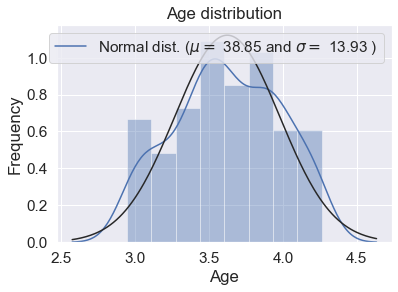

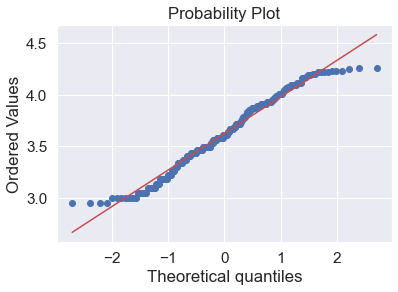

mu = 60.56 and sigma = 26.20


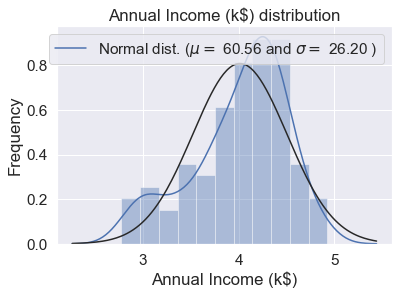

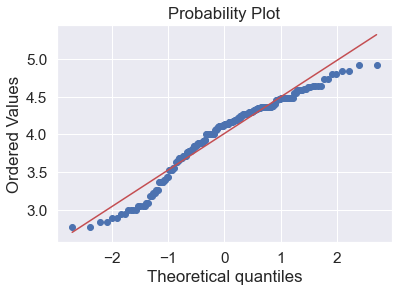

mu = 50.20 and sigma = 25.76


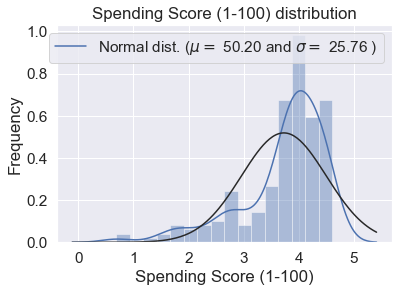

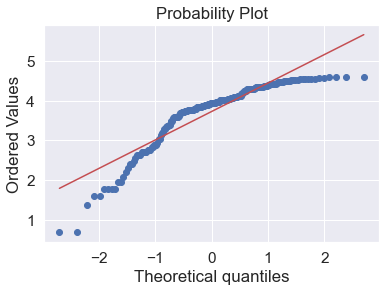

In [509]:
# Оценим распределения количественных признаков по их выборкам.
for num_feature in num_features:
    feature_log = np.log1p(df[num_feature])
    sns.distplot(feature_log, fit=stats.norm)
    mu, sigma = stats.norm.fit(df[num_feature])

    print(f'mu = {mu:.2f} and sigma = {sigma:.2f}')

    plt.legend(
    [f'Normal dist. ($\mu=$ {mu:.2f} and $\sigma=$ {sigma:.2f} )'], loc='best')
    plt.ylabel('Frequency')
    plt.title(f'{num_feature} distribution')

    # QQ-plot
    fig = plt.figure()
    res = stats.probplot(feature_log, plot=plt)
    plt.show()

**Вывод:** признак Annual Income имеет распределение близкое к нормальному.

### 1.3. Обработка выбросов в количественных признаках <a class="anchor" id="par1.3"></a>

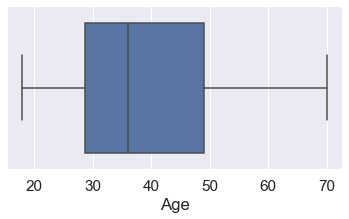

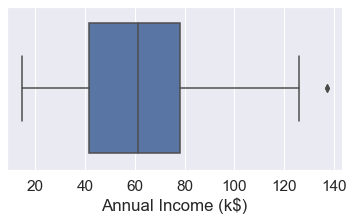

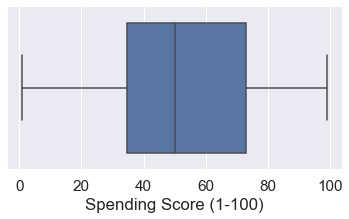

In [510]:
for num_feature in num_features:
    plt.figure(figsize=(6, 3))
    sns.boxplot(df[num_feature], whis=1.5)
    plt.xlabel(num_feature)
    plt.show()

В признаках Age и Spending Score выбросов нет. В признаке Annual Income (k$) есть выброс, определим его значение.

In [511]:
df['Annual Income (k$)'].value_counts().sort_index()

15     2
16     2
17     2
18     2
19     4
      ..
103    4
113    2
120    2
126    2
137    2
Name: Annual Income (k$), Length: 64, dtype: int64

Заменим выброс в признаке Annual Income (k$) медианой по этому признаку.

In [512]:
df.loc[df['Annual Income (k$)'] == 137, 'Annual Income (k$)'] = df['Annual Income (k$)'].median()

Проверяем, что в признаке Annual Income (k$) не осталось выбросов.

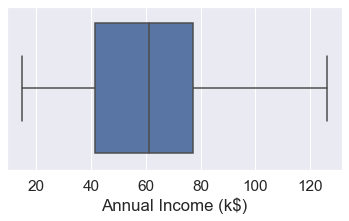

In [513]:
plt.figure(figsize=(6, 3))
sns.boxplot(df['Annual Income (k$)'], whis=1.5)
plt.xlabel('Annual Income (k$)')
plt.show()

**Вывод:** выбросы в количественных признаках удалены.

### 1.4. Анализ категориальных признаков <a class="anchor" id="par1.4"></a>

In [514]:
# Собираем категориальные признаки
cat_features = ['Genre']

In [515]:
# Смотрим значения признаков
for cat_feature in cat_features:
    print(str(cat_feature) + '\n\n' + str(df[cat_feature].value_counts()) + '\n' + '*' * 80 + '\n')

Genre

Female    112
Male       88
Name: Genre, dtype: int64
********************************************************************************



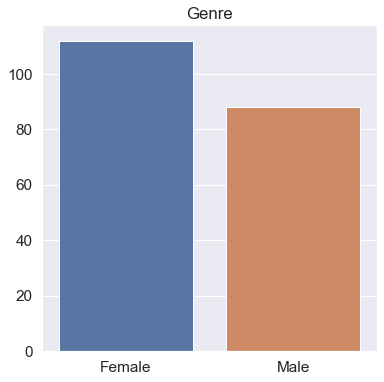

In [516]:
#смотрим распределение значений категориальных признаков
for cat_feature in cat_features:
    counts = df[cat_feature].value_counts()
    
    plt.figure(figsize=(6,6))    
    plt.title(cat_feature)
    sns.barplot(counts.index, counts.values)
    
    plt.show()

Преобразуем категориальные признаки в бинарные

In [517]:
df['Genre'] = df['Genre'].replace({'Female':0, 'Male':1})

Категориальный признак 'CustomerID' удаляем, поскольку он не несет никакой информации для кластеризации.

In [518]:
df = df.drop('CustomerID', axis = 1)
df.head(3)

,Genre,Age,Annual Income (k$),Spending Score (1-100)
0,1,19,15.0,39
1,1,21,15.0,81
2,0,20,16.0,6


**Вывод:** категориальный признак 'Genre' преобразован в бинарный, категориальный признак 'CustomerID' удален.

### 1.5. Оценка возможного числа кластеров <a class="anchor" id="par1.5"></a>

Рассмотрим диаграммы рассеивания по парам признаков

'Age' и 'Spending Score'

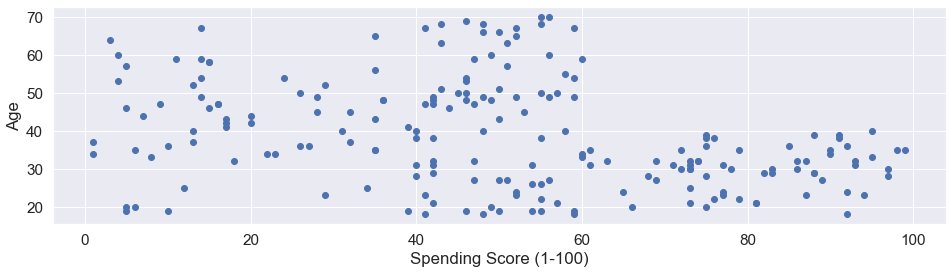

In [519]:
plt.figure(figsize=(16, 4))
plt.scatter(df['Spending Score (1-100)'], df['Age'])
plt.ylabel('Age')
plt.xlabel('Spending Score (1-100)')
plt.show()

Cреди покупателей старше 40 лет нет обладателей высокого Spending Score; \
Вывод 1: покупатели младше 40 лет тратят больше, покупатели старшe 40 тратят меньше.\
Таким образом, возможны 2 кластера.

'Genre' и 'Spending Score'

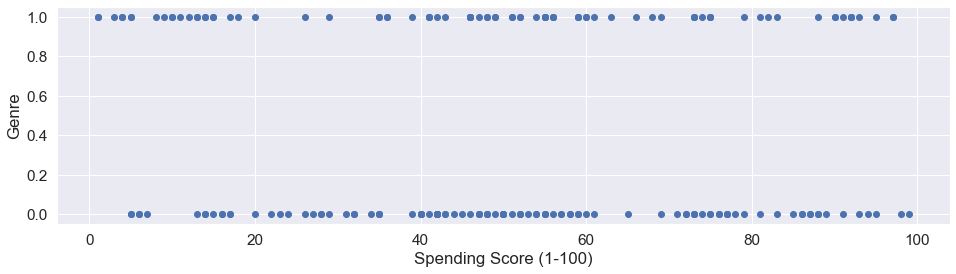

In [520]:
plt.figure(figsize=(16, 4))
plt.scatter(df['Spending Score (1-100)'], df['Genre'])
plt.ylabel('Genre')
plt.xlabel('Spending Score (1-100)')
plt.show()

Значения Spending Score от 40 до 60 больше у женщин, среди покупателей с Spending Score > 70 преобладают женщины.\
Вывод 2: взаимосвязь признаков явно не просматривается.\
Таким образом, сложно определить возможное число кластеров.

'Annual Income (k$)' и 'Spending Score'

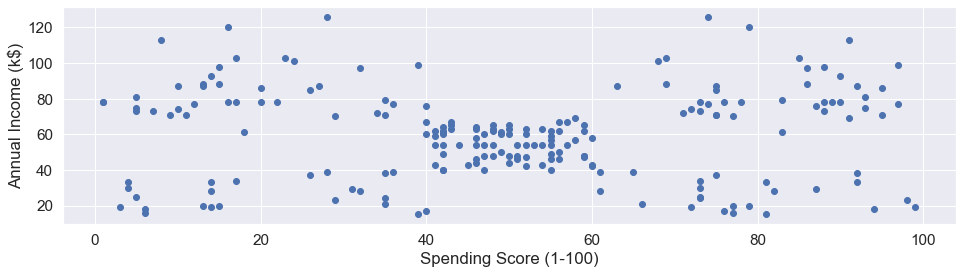

In [521]:
plt.figure(figsize=(16, 4))
plt.scatter(df['Spending Score (1-100)'], df['Annual Income (k$)'])
plt.ylabel('Annual Income (k$)')
plt.xlabel('Spending Score (1-100)')
plt.show()

Всех покупателей можно разделить на 5 классов в зависимости от уровня годового дохода и покупательского скоринга: \
1 -- покупатели, у которых Annual Income < 40 и Spending Score <= 40 \
2 -- покупатели, у которых 35 < = Annual Income <= 70 и 40 < Spending Score <= 60 \
2 -- покупатели, у которых Annual Income > 60 и Spending Score <= 40 \
3 -- покупатели, у которых 35 <=Annual Income <=70 и 35<= Spending Score <= 65 \
4 -- покупатели, у которых Annual Income < 50 и Spending Score > 60 \
5 -- покупатели, у которых Annual Income > 50 и Spending Score > 60 

**Вывод:** возможна сегментация покупателей на 5 непересекающихся классов.

## <center> Глава 2. Кластеризация методом KMeans <a class="anchor" id="part2"></a><center>

### 2.1. Определение оптимального числа кластеров <a class="anchor" id="par2.1"></a>

Определение оптимального количества кластеров (метод локтя)

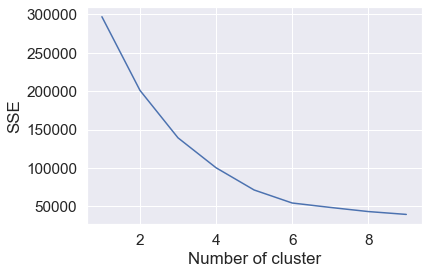

In [522]:
sse = {}
for k in range(1, 10):
    kmeans = KMeans(n_clusters=k, random_state=1).fit(df)
    sse[k] = kmeans.inertia_ # Inertia: Sum of distances of samples to their closest cluster center
plt.figure()
plt.plot(list(sse.keys()), list(sse.values()))
plt.xlabel("Number of cluster")
plt.ylabel("SSE")
plt.show()

Анализируя график, можно заключить, что оптимальное количество кластеров следует выбирать из значений 5 или 6.

Определение оптимального количества кластеров (метод силуэта)

In [523]:
for k in range(2, 10):
    kmeans = KMeans(n_clusters=k, random_state = 1).fit(df)
    label = kmeans.labels_
    sil_coeff = silhouette_score(df, label, metric='euclidean')
    print("For n_clusters={}, The Silhouette Coefficient is {}".format(k, sil_coeff))

For n_clusters=2, The Silhouette Coefficient is 0.2989758523929764
For n_clusters=3, The Silhouette Coefficient is 0.3755136910659857
For n_clusters=4, The Silhouette Coefficient is 0.4044567338692193
For n_clusters=5, The Silhouette Coefficient is 0.4453872753985074
For n_clusters=6, The Silhouette Coefficient is 0.4558478033009085
For n_clusters=7, The Silhouette Coefficient is 0.4381692987531987
For n_clusters=8, The Silhouette Coefficient is 0.4116066718936515
For n_clusters=9, The Silhouette Coefficient is 0.3991816631168294


Самый высокий коэффициент силуэта соответствует числу кластеров 6.
Проверим кластеризацию с k = 5 и k = 6 визуально.

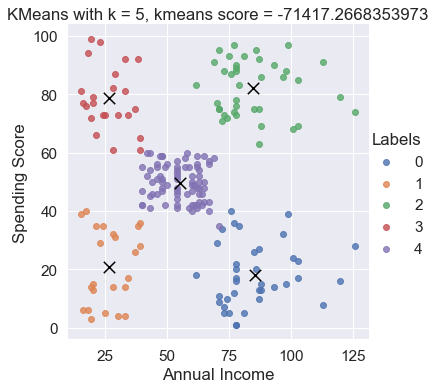

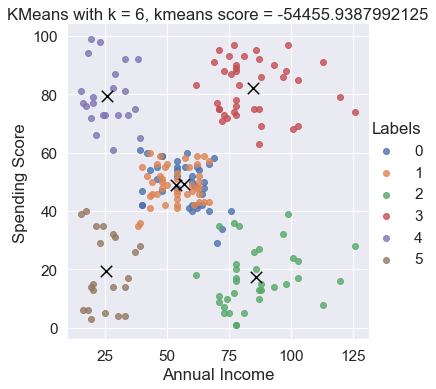

In [524]:
for k in [5, 6]:
    kmeans = KMeans(n_clusters=k).fit(df)

    #визуализируем предсказания
    data = pd.DataFrame({'Annual Income': df['Annual Income (k$)'],
                     'Spending Score': df['Spending Score (1-100)'],
                     'Labels': kmeans.labels_})

    sns.lmplot(data=data, x='Annual Income', y='Spending Score', hue='Labels', fit_reg=False, legend=True)

    plt.scatter(kmeans.cluster_centers_[:, 2], kmeans.cluster_centers_[:, 3], marker='x', s=130, c='black')
    plt.title('KMeans with k = {}, kmeans score = {}'.format(k,kmeans.score(df)))
    plt.show()

Из диаграмм видно, что лучшая кластеризация достигается при k = 5.

**Вывод:**  оптимальное значение k = 5.

### 2.2. Построение модели кластеризации KMeans и ее анализ <a class="anchor" id="par2.2"></a>

In [525]:
#оптимальное число кластеров
optimal_clust_num = 5

#создаем модель
model = KMeans(n_clusters = optimal_clust_num, random_state = 1)

#обучаем модель
model.fit(df)

#делаем предсказание
predictions = model.predict(df)
print(predictions)

[2 4 2 4 2 4 2 4 2 4 2 4 2 4 2 4 2 4 2 4 2 4 2 4 2 4 2 4 2 4 2 4 2 4 2 4 2
 4 2 4 2 4 2 0 2 4 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 1 3 1 3 1 3 1 3 1 3 1 3 1 3 1 3 1 3 1 3 1 3 1 3 1
 3 1 3 1 3 1 3 1 3 1 3 1 3 1 3 1 3 1 3 1 3 1 3 1 3 1 3 1 3 1 3 1 3 1 3 1 3
 1 3 1 3 1 3 1 3 1 3 1 3 1 3 1]


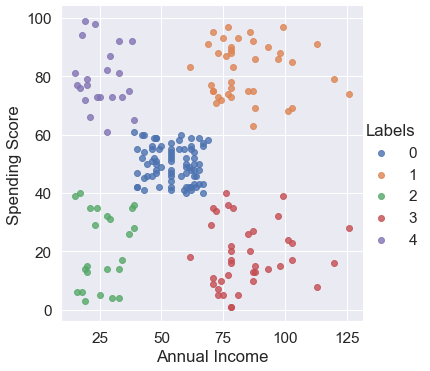

In [526]:
#визуализируем данные
data = pd.DataFrame({'Annual Income': df['Annual Income (k$)'],
                     'Spending Score': df['Spending Score (1-100)'],
                     'Labels': model.labels_})

sns.lmplot(data=data, x='Annual Income', y='Spending Score', hue='Labels', fit_reg=False, legend=True)

Исходя из диаграммы, имеем:\
кластер 0 -- покупатели со средним годовым доходом и средним покупательским скорингом,\
кластер 1 -- покупатели с высоким годовым доходом и высоким покупательским скорингом,\
кластер 2 -- покупатели с низким годовым доходом и низким покупательским скорингом,\
кластер 3 -- покупатели с высоким годовым доходом и низким покупательским скорингом,\
кластер 4 -- покупатели с низким годовым доходом и высоким покупательским скорингом.

Наглядное представление кластеров покупателей

In [527]:
from IPython.display import HTML, display
display(HTML("<table><tr><td><p>Кластер 0</p><img src='static/claster_0.jpg'></td><td><p>Кластер 1</p><img src='static/claster_1.jpg'></td><td><p>Кластер 2</p><img src='static/claster_2.png'></td><td><p>Кластер 3</p><img src='static/claster_3.png'></td><td><p>Кластер 4</p><img src='static/claster_4.png'></td></tr></table>"))

Кластер 0,Кластер 1,Кластер 2,Кластер 3,Кластер 4


Визуализация кластеризации методом t-SNE

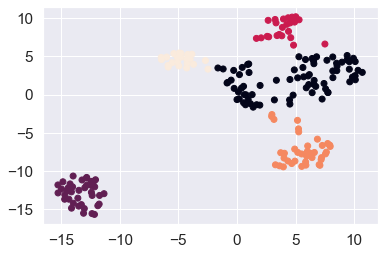

In [528]:
from sklearn.manifold import TSNE
model_tsne = TSNE(learning_rate = 100, random_state=1)
transformed = model_tsne.fit_transform(df)
x_axis = transformed[:,0]
y_axis = transformed[:,1]
plt.scatter(x_axis,y_axis,c=model.labels_)
plt.show()

Убедимся, что признак 'Genre' не оказывает влияние на формирование кластеров.

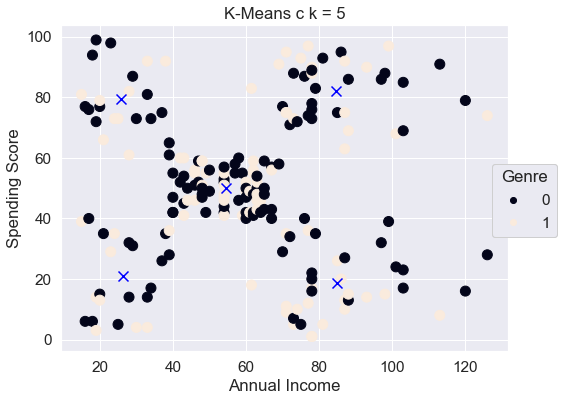

In [529]:
ax=plt.figure(figsize=(8, 6))

scatter=plt.scatter(df['Annual Income (k$)'], 
            df['Spending Score (1-100)'], 
            c=df['Genre'], s=100)

plt.scatter(model.cluster_centers_[:,2], model.cluster_centers_[:,3], color='blue', marker='x', s=100) 

legend1 = ax.legend(*scatter.legend_elements(), loc="right", title="Genre")
ax.add_artist(legend1)

plt.xlabel('Annual Income')
plt.ylabel('Spending Score')
plt.title('K-Means c k = 5')

plt.show()

Из диаграммы видно, что нельзя выделить кластер по преобладанию того или иного пола.

**Вывод:** построена модель кластеризации KMeans с параметром k = 5.

### 2.3. Сохранение итоговой модели <a class="anchor" id="par2.3"></a>

Сохранение итоговой модели

In [530]:
with open("KMeans.pkl", "wb") as f:
    pickle.dump(model, f)